### Exploratory analysis: Air pollution geoloc

In [96]:
import pandas as pd
import numpy as np 
import seaborn as sns
import json

import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point

### data source
#: https://a816-dohbesp.nyc.gov/IndicatorPublic/data-explorer/air-quality/?id=2023#display=summary


# NYC street level monitors
https://a816-dohbesp.nyc.gov/IndicatorPublic/data-features/realtime-air-quality/

In [8]:
raw = pd.read_csv("NYC EH Data Portal - Fine particles (PM 2.5) (filtered) (1).csv")
raw.head()

TimePeriod GeoTypeDesc  GeoID  GeoRank      Geography  \
0  Winter 2021-22    Citywide      1        0  New York City   
1  Winter 2021-22     Borough      1        1          Bronx   
2  Winter 2021-22     Borough      2        1       Brooklyn   
3  Winter 2021-22     Borough      3        1      Manhattan   
4  Winter 2021-22     Borough      4        1         Queens   

   10th percentile mcg/m3  90th percentile mcg/m3  Mean mcg/m3  
0                     6.0                     7.5          6.8  
1                     6.9                     7.6          7.3  
2                     6.4                     7.5          6.9  
3                     6.8                     9.9          7.9  
4                     6.2                     7.3          6.7

In [10]:
raw['Geography'].value_counts()

Geography
Upper West Side                      12
East Flatbush - Flatbush             12
Rockaways                            12
Southeast Queens                     12
Jamaica                              12
                                     ..
South Beach - Tottenville             6
Willowbrook                           6
Stapleton - St. George                6
Port Richmond                         6
Tottenville and Great Kills (CD3)     6
Name: count, Length: 114, dtype: int64

In [133]:
raw[raw['GeoTypeDesc']=='Borough']['Geography'].value_counts()

Geography
Bronx            6
Brooklyn         6
Manhattan        6
Queens           6
Staten Island    6
Name: count, dtype: int64

In [ ]:
raw_july = pd.read_csv("hourlyMonitoringJuly2024.csv")
loc_json = json.load(open('location.json', 'r')) #JSON DOESN"T MATCH: NYC EH Data Portal - Fine particles (PM 2.5) (filtered) (1).csv

In [58]:
# july process
raw_july['ObservationTimeUTC'] = pd.to_datetime(raw_july['ObservationTimeUTC'])

In [60]:
raw_july['SiteID'].value_counts()

SiteID
36061NY08454    744
36061NY08653    744
36005NY12387    744
36061NY09734    744
36085NY04805    744
36005NY11534    743
36047NY07974    679
36061NY10130    679
36081NY07615    297
36061NY12380    223
36061NY08552     79
36081NY09285     53
36081NY08198      1
Name: count, dtype: int64

In [70]:
day_mean = raw_july.groupby(pd.Grouper(key='ObservationTimeUTC', freq='D',))['Value'].mean()

In [74]:
day_loc_mean = raw_july.groupby([pd.Grouper(key='ObservationTimeUTC', freq='D'), 'SiteID'])['Value'].mean().reset_index()
day_loc_mean

ObservationTimeUTC        SiteID      Value
0           2024-07-01  36005NY11534   4.357917
1           2024-07-01  36005NY12387   5.525833
2           2024-07-01  36061NY08454   5.335000
3           2024-07-01  36061NY08552   5.600417
4           2024-07-01  36061NY08653   4.779583
..                 ...           ...        ...
271         2024-07-31  36061NY10130   8.944167
272         2024-07-31  36061NY12380  10.820000
273         2024-07-31  36081NY07615   8.346667
274         2024-07-31  36081NY09285   7.500000
275         2024-07-31  36085NY04805   9.402500

[276 rows x 3 columns]

In [102]:
loc_json_gpd = gpd.GeoDataFrame(
    loc_json,
    geometry=[Point(xy) for xy in zip([loc['Longitude'] for loc in loc_json], [loc['Latitude'] for loc in loc_json])]
)
centroid = loc_json_gpd.geometry.unary_union.centroid
center = {"lat": centroid.y, "lon": centroid.x}

In [120]:
# MUST MERGE DATA ON GEO DF TO MAKE PLOT
day_loc_mean = pd.merge(day_loc_mean, loc_json_gpd, on = 'SiteID', how='inner')

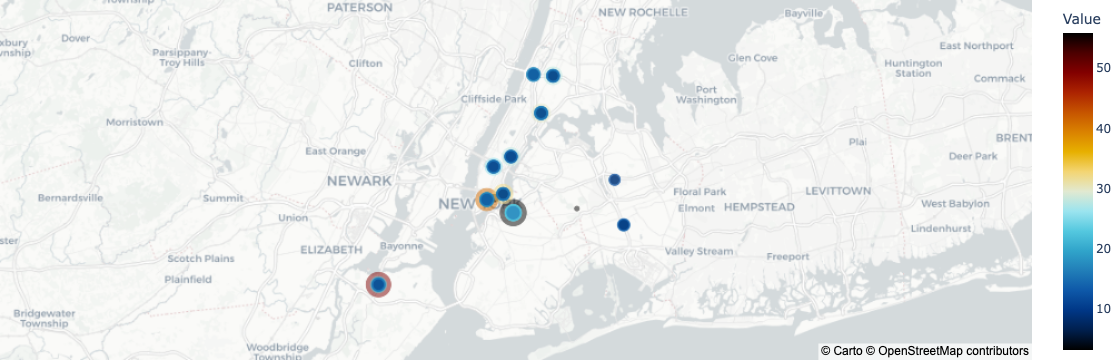

In [130]:
# JULY PARTICULARE MATTER MONTH MEANS
fig = px.scatter_mapbox(day_loc_mean,
                        lat='Latitude', lon='Longitude', hover_name = 'SiteName',
                        hover_data={'Value':True,'SiteName':True},
                        color="Value",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=9,
                        opacity=0.5,
                        size='Value',
                        center=center,
                        mapbox_style="carto-positron")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [138]:
#json merge
july_dat_gpd = pd.merge(raw_july, loc_json_gpd, on = 'SiteID', how='inner')

In [142]:
july_dat_gpd.head(2)

ID        SiteID ObservationTimeUTC  Value   Latitude  Longitude  \
0  575923  36061NY08552         2024-07-01  10.61  40.718073 -73.986059   
1  575924  36061NY08454         2024-07-01  13.93  40.716510 -73.997004   

              SiteName                          Address  \
0  Williamsburg Bridge  Delancey St NS 1E of Suffolk St   
1     Manhattan Bridge    Canal St SS1E of Elizabeth St   

                     geometry  
0  POINT (-73.98606 40.71807)  
1  POINT (-73.99700 40.71651)

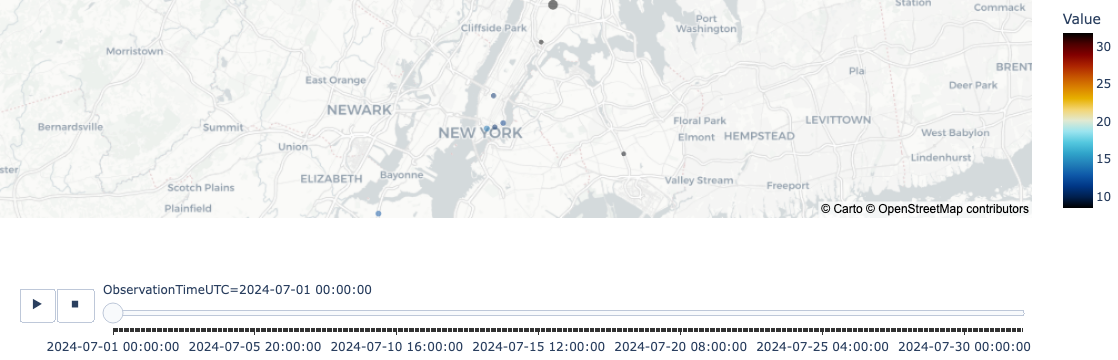

In [144]:
fig = px.scatter_mapbox(july_dat_gpd,
                        lat='Latitude', lon='Longitude', hover_name = 'SiteName',
                        hover_data={'Value':True,'SiteName':True},
                        color="Value",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        zoom=9,
                        opacity=0.5,
                        size='Value',
                        animation_frame='ObservationTimeUTC',
                        center=center,
                        mapbox_style="carto-positron")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [136]:
raw_july.head()

ID        SiteID ObservationTimeUTC  Value
0  575923  36061NY08552         2024-07-01  10.61
1  575924  36061NY08454         2024-07-01  13.93
2  575927  36061NY08653         2024-07-01  11.54
3  575928  36081NY07615         2024-07-01   8.68
4  575939  36005NY12387         2024-07-01  31.87